In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [11]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 1/'
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
import os
import numpy as np
import torch
import time
import torch.nn as nn
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torchvision import datasets
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import copy
from torch.utils.tensorboard import SummaryWriter

# Create writer for tensorboard
writer = SummaryWriter('runs/Resnet')

In [13]:
# Slight data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

#Create datasets in dictionary with for loop passing in dir names and adding transform to tensor and normalize
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),data_transforms[x])
                  for x in ['train', 'val', 'test']}
#Load datasets in same way shuffle and make batch size 4 this can be tuned, workers at 2 for colab
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
#Similar process read in dataset sizes for accuracy later on
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#Read in classes from train, could be any as long as all directories have all classes
class_names = image_datasets['train'].classes

#Change to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Check what device is being used as well as dataset sizes
print(device)
print(dataset_sizes)

cuda:0
{'train': 1287, 'val': 389, 'test': 412}


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  """
  Function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion loss function
    optimizer: Optimizer to use for training
    scheduler: Instance of torch.optim.lr_scheduler
    num_epochs: Number of epochs
    device: Device to run the training on, CUDA or CPU on colab.
  """
  #Time taken to train start
  since = time.time()

  #Copy current weights 
  best_model_wts = copy.deepcopy(model.state_dict())
  #Set accuracy
  best_acc = 0.0
  
  #For loop for training
  for epoch in range(num_epochs):
    #Printing epochs
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      #Set running loss and correct count
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        #Send to device for training
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      #Step each train
      if phase == 'train':
        scheduler.step()
      #Calculate loss and accuracy
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      #Print loss accuracy and phase
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #Send to tensorboard to be plotted
      if phase == 'train':
          writer.add_scalar('Training Loss', epoch_loss/1000, epoch * len(dataloaders['train']))
          writer.add_scalar('Training Accuracy', epoch_acc, epoch)
      else:
        writer.add_scalar('Validaiton Loss', epoch_loss/1000, epoch * len(dataloaders['val']))
        writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

      # deep copy the model when decent score
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  #When complete calc time taken
  time_elapsed = time.time() - since
  #Print time taken and validation accuracy 
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights and send back trained model
  model.load_state_dict(best_model_wts)
  return model

In [15]:
#Call resnet18 model
resnet = torchvision.models.resnet18(pretrained=True)
#for each param set requires_grad to false
for param in resnet.parameters():
    param.requires_grad = False

#Set number of features to the num of features model will look for
num_ftrs = resnet.fc.in_features
#Set feautres value and send num of classes
resnet.fc = nn.Linear(num_ftrs, 6)
#Set to device
resnet = resnet.to(device)
#Create loss function 
criterion = nn.CrossEntropyLoss() 

#Create optimiser for model
optimizer_conv = optim.Adam(resnet.fc.parameters(), lr=0.001)

#Set scheduler, decay learning rate by a factor of 0.3 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.3)

Epoch 0/24
----------
train Loss: 1.4936 Acc: 0.3994
val Loss: 1.0059 Acc: 0.6195

Epoch 1/24
----------
train Loss: 1.1476 Acc: 0.5742
val Loss: 0.6433 Acc: 0.8149

Epoch 2/24
----------
train Loss: 0.9313 Acc: 0.6744
val Loss: 0.5721 Acc: 0.8098

Epoch 3/24
----------
train Loss: 0.8699 Acc: 0.6970
val Loss: 0.6483 Acc: 0.7712

Epoch 4/24
----------
train Loss: 0.8088 Acc: 0.7195
val Loss: 0.4649 Acc: 0.8663

Epoch 5/24
----------
train Loss: 0.7252 Acc: 0.7420
val Loss: 0.4328 Acc: 0.8869

Epoch 6/24
----------
train Loss: 0.6989 Acc: 0.7576
val Loss: 0.4167 Acc: 0.8843

Epoch 7/24
----------
train Loss: 0.6672 Acc: 0.7754
val Loss: 0.3819 Acc: 0.8869

Epoch 8/24
----------
train Loss: 0.7407 Acc: 0.7568
val Loss: 0.3966 Acc: 0.8972

Epoch 9/24
----------
train Loss: 0.6958 Acc: 0.7653
val Loss: 0.3918 Acc: 0.9023

Epoch 10/24
----------
train Loss: 0.6819 Acc: 0.7731
val Loss: 0.3753 Acc: 0.8895

Epoch 11/24
----------
train Loss: 0.6559 Acc: 0.7786
val Loss: 0.3852 Acc: 0.8895

Ep

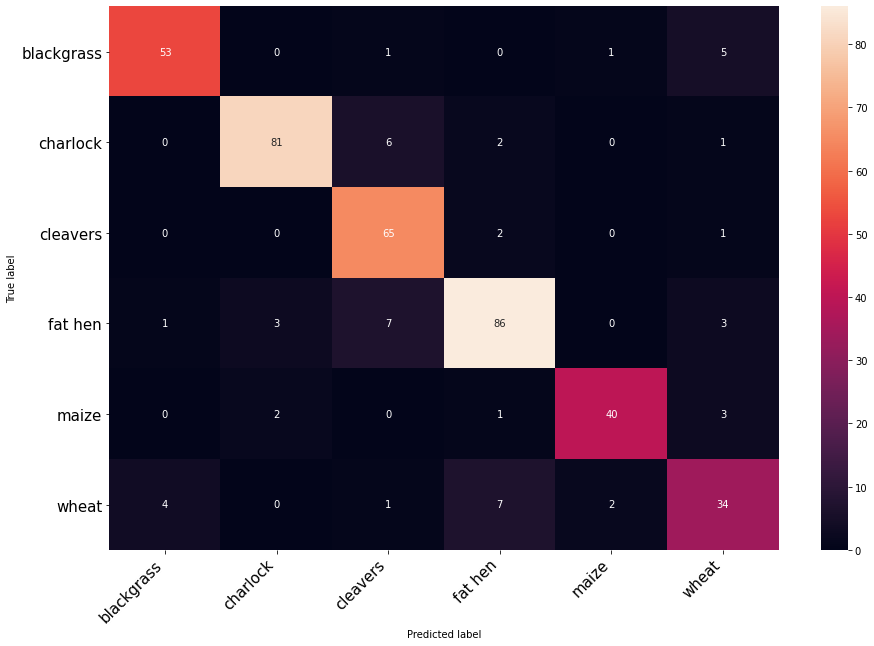

In [16]:
#Train model
resnet = train_model(resnet, criterion, optimizer_conv, exp_lr_scheduler,
                             num_epochs=25, device=device)

#Call test data
images, labels = next(iter(dataloaders['test']))
#Send images to device to test and send to tensorboard same as model
images = images.to(device)
#Send to tensorboard
writer.add_graph(resnet, images)
#Time to test model
print("Testing model")
#Set confusion matric up as 6x6 (num of classes)
confusion_matrix = torch.zeros(6, 6)
#For loop for test and assigning to confusion matrix for multi class
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['test']):
        #Set images and labels to same device as model
        images = images.to(device)
        labels = labels.to(device)
        #Pass model image
        outputs = resnet(images)
        #Compare model prediction with actual
        _, pred = torch.max(outputs, 1)
        #For loop to add to confusion matrix
        for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1
#Print matrix created
print(confusion_matrix)
#Find each class accuracy
accuracy_individ = confusion_matrix.diag()/confusion_matrix.sum(1)
#Print each class accuracy
print(accuracy_individ)

#Plot figure for easier understanding of model
plt.figure(figsize=(15,10))
#Set to dataframe for seaborn heatmap
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#Call heatmap with dataframe
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#Call heatmap with dataframe
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
#Save for later use
conf = root_path + "Conf_matrix_Resnet.png"
plt.savefig(conf)

In [17]:
#convert accuracies to numpy
accuracy_indi = accuracy_individ.numpy()
#Convert matrix to numpy
matrix = confusion_matrix.numpy()
#Total up each class verical from matrix
totals = np.sum(matrix, axis = 1)
#Total up each class horizontal from matrix
fp_total = np.sum(matrix, axis = 0)


overall_total = sum(totals + fp_total)
#Evaluation metrics for loop
for i in range(6):
  total = totals[i]
  TP = total * accuracy_indi[i]
  FN = total - TP
  FP = fp_total[i] - TP
  TN = overall_total -(total + fp_total[i])
  Accuracy = (TP + TN)/ (TP + FP + TN + FN)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  F1 = (2*TP) / (2*TP + FP + FN)
  MCC = ((TP * TN) - (FP *FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) )
  Error_rate = (FP + FN)/ (TP + FP + TN + FN) 
  Sensitivity = TP / (TP +FN)
  print(class_names[i].capitalize())
  print("True Positive value = " + str(TP))
  print("False Negative value = " + str(FN))
  print("False Positive value = " + str(FP))
  print("True Negative value = " + str(TN))
  print("Accuracy = " + str(Accuracy))
  print("Precision = " + str(Precision))
  print("Recall = " + str(Recall))
  print("Specificity = " + str(Specificity))
  print("F1 Score = " + str(F1))
  print("MCC = " + str(MCC))
  print("Error Rate = " + str(Error_rate))
  print("Sensitivity = " + str(Sensitivity))
  print()

#Save the model for later use to be deployed using torchserve
s = torch.jit.script(resnet)
torch.jit.save(s, root_path + 'Resnet18.pt')

Blackgrass
True Positive value = 53.0
False Negative value = 7.0
False Positive value = 5.0
True Negative value = 706.0
Accuracy = 0.9844357976653697
Precision = 0.9137931
Recall = 0.8833333
Specificity = 0.9929676511954993
F1 Score = 0.8983050847457628
MCC = 0.8900306515705787
Error Rate = 0.01556420233463035
Sensitivity = 0.8833333

Charlock
True Positive value = 81.0
False Negative value = 9.0
False Positive value = 5.0
True Negative value = 648.0
Accuracy = 0.9811574697173621
Precision = 0.94186044
Recall = 0.9
Specificity = 0.9923430321592649
F1 Score = 0.9204545454545454
MCC = 0.9100762309608627
Error Rate = 0.018842530282637954
Sensitivity = 0.9

Cleavers
True Positive value = 65.0
False Negative value = 3.0
False Positive value = 15.0
True Negative value = 676.0
Accuracy = 0.9762845849802372
Precision = 0.8125
Recall = 0.9558824
Specificity = 0.9782923299565847
F1 Score = 0.8783783783783784
MCC = 0.868843772614668
Error Rate = 0.023715415019762844
Sensitivity = 0.9558824

Fat h

In [18]:
!tensorboard dev upload \
  --logdir  runs/Resnet/\
  --name "Resnet18  Model" \
  --description "Relevant information on model found here" \
  --one_shot

2021-04-19 23:50:00.719578: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Z0pXxKibSZCyqSzu85j1SA/

[2021-04-19T23:50:02] Started scanning logdir.
[2021-04-19T23:50:03] Total uploaded: 200 scalars, 0 tensors, 1 binary objects (82.5 kB)
[2021-04-19T23:50:03] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Z0pXxKibSZCyqSzu85j1SA/
